In [46]:
import pandas as pd
import numpy as np
#from prophet import Prophet
from darts.models import Prophet
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries, concatenate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from pandas import Timestamp

In [47]:
df = pd.read_csv('EDvisitfileL.csv', encoding='ISO-8859-1')

# 确保'date'列是DateTime类型
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.rename(columns={'No_Linkou': 'No'})

# 分割数据集为训练集、验证集和测试集（假设您已经根据时间排序）
#train_proportion = 0.5
#val_proportion = 0.3

# Calculate the split indices
total_length = len(df)
train_end = 3645
#val_end = train_end + int(total_length * val_proportion)

# Split the DataFrame1
train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]

# 步骤2: 使用MinMaxScaler缩放数据
# 定义并拟合scaler
scaler = MinMaxScaler()
scaler.fit(train_df[['No']])  # 只用训练数据拟合scaler

# 缩放训练集和验证集
train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
test_df.loc[:, 'No_scaled'] = scaler.transform(test_df[['No']])  # 用相同的scaler转换测试集以避免数据泄露

train_series = TimeSeries.from_dataframe(train_df, value_cols='No_scaled' )
test_series = TimeSeries.from_dataframe(test_df, value_cols='No_scaled' )

# 原始数据转换为TimeSeries对象，如果需要
train_series_origin = TimeSeries.from_dataframe(train_df, value_cols='No'  )
test_series_origin = TimeSeries.from_dataframe(test_df, value_cols='No' )

# 选择需要的列创建多变量时间序列(都是one hot coding)
columns = ['Dayoff', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun',  'YearScaled', 'MonthScaled', 'Dayscaled', 'NewYear', '3Lock']
df_multivariate = df[columns]

# 将DataFrame转换为多变量时间序列
ED_covariates = TimeSeries.from_dataframe(df_multivariate ) 

C:\Users\ian11\AppData\Local\Temp\ipykernel_9608\878113695.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
C:\Users\ian11\AppData\Local\Temp\ipykernel_9608\878113695.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'No_scaled'] = scaler.transform(test_df[['No']])  # 用相同的scaler转换测试集以避免数据泄露


In [48]:
model = Prophet(add_seasonalities=None, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)
model.fit(train_series)

21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [65]:
forecast_horizon = 60
# Forecast horizon
stride = 1            # Stride for each forecast
retrain = True
#start_date = Timestamp('2017-10-01') 

# Assuming 'test_series' and 'ED_covariates' are properly defined Darts TimeSeries objects

# Perform the historical forecast
backtest_series = model.historical_forecasts(
    series=test_series,
    forecast_horizon=forecast_horizon,
    #start=start_date,
    stride=stride,
    retrain=retrain,
    verbose=True,
)

# Convert the forecasted TimeSeries to DataFrame and apply inverse transformation
Model_prediction_df = backtest_series.pd_dataframe()

# Assuming 'scaler' is previously defined and fitted Scaler object
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                                           index=Model_prediction_df.index,
                                           columns=Model_prediction_df.columns)

# Convert the inverse-transformed DataFrame back to a TimeSeries
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)



  0%|          | 0/1764 [00:00<?, ?it/s]

22:08:05 - cmdstanpy - INFO - Chain [1] start processing
22:08:05 - cmdstanpy - INFO - Chain [1] done processing
22:08:05 - cmdstanpy - INFO - Chain [1] start processing
22:08:05 - cmdstanpy - INFO - Chain [1] done processing
22:08:05 - cmdstanpy - INFO - Chain [1] start processing
22:08:05 - cmdstanpy - INFO - Chain [1] done processing
22:08:05 - cmdstanpy - INFO - Chain [1] start processing
22:08:05 - cmdstanpy - INFO - Chain [1] done processing
22:08:05 - cmdstanpy - INFO - Chain [1] start processing
22:08:06 - cmdstanpy - INFO - Chain [1] done processing
22:08:06 - cmdstanpy - INFO - Chain [1] start processing
22:08:06 - cmdstanpy - INFO - Chain [1] done processing
22:08:06 - cmdstanpy - INFO - Chain [1] start processing
22:08:06 - cmdstanpy - INFO - Chain [1] done processing
22:08:06 - cmdstanpy - INFO - Chain [1] start processing
22:08:06 - cmdstanpy - INFO - Chain [1] done processing
22:08:06 - cmdstanpy - INFO - Chain [1] start processing
22:08:06 - cmdstanpy - INFO - Chain [1]

22:08:25 - cmdstanpy - INFO - Chain [1] done processing
22:08:25 - cmdstanpy - INFO - Chain [1] start processing
22:08:25 - cmdstanpy - INFO - Chain [1] done processing
22:08:25 - cmdstanpy - INFO - Chain [1] start processing
22:08:26 - cmdstanpy - INFO - Chain [1] done processing
22:08:26 - cmdstanpy - INFO - Chain [1] start processing
22:08:26 - cmdstanpy - INFO - Chain [1] done processing
22:08:26 - cmdstanpy - INFO - Chain [1] start processing
22:08:26 - cmdstanpy - INFO - Chain [1] done processing
22:08:26 - cmdstanpy - INFO - Chain [1] start processing
22:08:27 - cmdstanpy - INFO - Chain [1] done processing
22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:08:27 - cmdstanpy - INFO - Chain [1] done processing
22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:08:27 - cmdstanpy - INFO - Chain [1] done processing
22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:08:28 - cmdstanpy - INFO - Chain [1] done processing
22:08:28 - cmdstanpy - INFO - Chain [1] 

22:08:42 - cmdstanpy - INFO - Chain [1] done processing
22:08:42 - cmdstanpy - INFO - Chain [1] start processing
22:08:43 - cmdstanpy - INFO - Chain [1] done processing
22:08:43 - cmdstanpy - INFO - Chain [1] start processing
22:08:43 - cmdstanpy - INFO - Chain [1] done processing
22:08:43 - cmdstanpy - INFO - Chain [1] start processing
22:08:43 - cmdstanpy - INFO - Chain [1] done processing
22:08:43 - cmdstanpy - INFO - Chain [1] start processing
22:08:43 - cmdstanpy - INFO - Chain [1] done processing
22:08:43 - cmdstanpy - INFO - Chain [1] start processing
22:08:43 - cmdstanpy - INFO - Chain [1] done processing
22:08:43 - cmdstanpy - INFO - Chain [1] start processing
22:08:43 - cmdstanpy - INFO - Chain [1] done processing
22:08:44 - cmdstanpy - INFO - Chain [1] start processing
22:08:44 - cmdstanpy - INFO - Chain [1] done processing
22:08:44 - cmdstanpy - INFO - Chain [1] start processing
22:08:44 - cmdstanpy - INFO - Chain [1] done processing
22:08:44 - cmdstanpy - INFO - Chain [1] 

22:08:56 - cmdstanpy - INFO - Chain [1] done processing
22:08:56 - cmdstanpy - INFO - Chain [1] start processing
22:08:56 - cmdstanpy - INFO - Chain [1] done processing
22:08:56 - cmdstanpy - INFO - Chain [1] start processing
22:08:56 - cmdstanpy - INFO - Chain [1] done processing
22:08:56 - cmdstanpy - INFO - Chain [1] start processing
22:08:56 - cmdstanpy - INFO - Chain [1] done processing
22:08:56 - cmdstanpy - INFO - Chain [1] start processing
22:08:57 - cmdstanpy - INFO - Chain [1] done processing
22:08:57 - cmdstanpy - INFO - Chain [1] start processing
22:08:57 - cmdstanpy - INFO - Chain [1] done processing
22:08:57 - cmdstanpy - INFO - Chain [1] start processing
22:08:57 - cmdstanpy - INFO - Chain [1] done processing
22:08:57 - cmdstanpy - INFO - Chain [1] start processing
22:08:57 - cmdstanpy - INFO - Chain [1] done processing
22:08:57 - cmdstanpy - INFO - Chain [1] start processing
22:08:57 - cmdstanpy - INFO - Chain [1] done processing
22:08:57 - cmdstanpy - INFO - Chain [1] 

22:09:09 - cmdstanpy - INFO - Chain [1] done processing
22:09:09 - cmdstanpy - INFO - Chain [1] start processing
22:09:09 - cmdstanpy - INFO - Chain [1] done processing
22:09:09 - cmdstanpy - INFO - Chain [1] start processing
22:09:09 - cmdstanpy - INFO - Chain [1] done processing
22:09:10 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing
22:09:10 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing
22:09:10 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing
22:09:10 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing
22:09:11 - cmdstanpy - INFO - Chain [1] start processing
22:09:11 - cmdstanpy - INFO - Chain [1] done processing
22:09:11 - cmdstanpy - INFO - Chain [1] start processing
22:09:11 - cmdstanpy - INFO - Chain [1] done processing
22:09:11 - cmdstanpy - INFO - Chain [1] 

22:09:23 - cmdstanpy - INFO - Chain [1] done processing
22:09:23 - cmdstanpy - INFO - Chain [1] start processing
22:09:23 - cmdstanpy - INFO - Chain [1] done processing
22:09:23 - cmdstanpy - INFO - Chain [1] start processing
22:09:23 - cmdstanpy - INFO - Chain [1] done processing
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
22:09:24 - cmdstanpy - INFO - Chain [1] done processing
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
22:09:24 - cmdstanpy - INFO - Chain [1] done processing
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
22:09:24 - cmdstanpy - INFO - Chain [1] done processing
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
22:09:24 - cmdstanpy - INFO - Chain [1] done processing
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
22:09:24 - cmdstanpy - INFO - Chain [1] done processing
22:09:25 - cmdstanpy - INFO - Chain [1] start processing
22:09:25 - cmdstanpy - INFO - Chain [1] done processing
22:09:25 - cmdstanpy - INFO - Chain [1] 

22:09:38 - cmdstanpy - INFO - Chain [1] done processing
22:09:38 - cmdstanpy - INFO - Chain [1] start processing
22:09:38 - cmdstanpy - INFO - Chain [1] done processing
22:09:38 - cmdstanpy - INFO - Chain [1] start processing
22:09:38 - cmdstanpy - INFO - Chain [1] done processing
22:09:38 - cmdstanpy - INFO - Chain [1] start processing
22:09:38 - cmdstanpy - INFO - Chain [1] done processing
22:09:38 - cmdstanpy - INFO - Chain [1] start processing
22:09:39 - cmdstanpy - INFO - Chain [1] done processing
22:09:39 - cmdstanpy - INFO - Chain [1] start processing
22:09:39 - cmdstanpy - INFO - Chain [1] done processing
22:09:39 - cmdstanpy - INFO - Chain [1] start processing
22:09:39 - cmdstanpy - INFO - Chain [1] done processing
22:09:39 - cmdstanpy - INFO - Chain [1] start processing
22:09:39 - cmdstanpy - INFO - Chain [1] done processing
22:09:39 - cmdstanpy - INFO - Chain [1] start processing
22:09:39 - cmdstanpy - INFO - Chain [1] done processing
22:09:39 - cmdstanpy - INFO - Chain [1] 

22:09:53 - cmdstanpy - INFO - Chain [1] done processing
22:09:53 - cmdstanpy - INFO - Chain [1] start processing
22:09:53 - cmdstanpy - INFO - Chain [1] done processing
22:09:53 - cmdstanpy - INFO - Chain [1] start processing
22:09:53 - cmdstanpy - INFO - Chain [1] done processing
22:09:53 - cmdstanpy - INFO - Chain [1] start processing
22:09:53 - cmdstanpy - INFO - Chain [1] done processing
22:09:53 - cmdstanpy - INFO - Chain [1] start processing
22:09:54 - cmdstanpy - INFO - Chain [1] done processing
22:09:54 - cmdstanpy - INFO - Chain [1] start processing
22:09:54 - cmdstanpy - INFO - Chain [1] done processing
22:09:54 - cmdstanpy - INFO - Chain [1] start processing
22:09:54 - cmdstanpy - INFO - Chain [1] done processing
22:09:54 - cmdstanpy - INFO - Chain [1] start processing
22:09:54 - cmdstanpy - INFO - Chain [1] done processing
22:09:54 - cmdstanpy - INFO - Chain [1] start processing
22:09:54 - cmdstanpy - INFO - Chain [1] done processing
22:09:54 - cmdstanpy - INFO - Chain [1] 

22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] start processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] start processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] start processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] start processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] start processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:10 - cmdstanpy - INFO - Chain [1] start processing
22:10:10 - cmdstanpy - INFO - Chain [1] done processing
22:10:10 - cmdstanpy - INFO - Chain [1] 

22:10:23 - cmdstanpy - INFO - Chain [1] done processing
22:10:23 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing
22:10:24 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing
22:10:24 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing
22:10:24 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing
22:10:24 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] 

22:10:39 - cmdstanpy - INFO - Chain [1] done processing
22:10:39 - cmdstanpy - INFO - Chain [1] start processing
22:10:40 - cmdstanpy - INFO - Chain [1] done processing
22:10:40 - cmdstanpy - INFO - Chain [1] start processing
22:10:40 - cmdstanpy - INFO - Chain [1] done processing
22:10:40 - cmdstanpy - INFO - Chain [1] start processing
22:10:40 - cmdstanpy - INFO - Chain [1] done processing
22:10:40 - cmdstanpy - INFO - Chain [1] start processing
22:10:40 - cmdstanpy - INFO - Chain [1] done processing
22:10:41 - cmdstanpy - INFO - Chain [1] start processing
22:10:41 - cmdstanpy - INFO - Chain [1] done processing
22:10:41 - cmdstanpy - INFO - Chain [1] start processing
22:10:41 - cmdstanpy - INFO - Chain [1] done processing
22:10:41 - cmdstanpy - INFO - Chain [1] start processing
22:10:41 - cmdstanpy - INFO - Chain [1] done processing
22:10:41 - cmdstanpy - INFO - Chain [1] start processing
22:10:41 - cmdstanpy - INFO - Chain [1] done processing
22:10:42 - cmdstanpy - INFO - Chain [1] 

22:11:00 - cmdstanpy - INFO - Chain [1] done processing
22:11:01 - cmdstanpy - INFO - Chain [1] start processing
22:11:01 - cmdstanpy - INFO - Chain [1] done processing
22:11:01 - cmdstanpy - INFO - Chain [1] start processing
22:11:01 - cmdstanpy - INFO - Chain [1] done processing
22:11:01 - cmdstanpy - INFO - Chain [1] start processing
22:11:02 - cmdstanpy - INFO - Chain [1] done processing
22:11:02 - cmdstanpy - INFO - Chain [1] start processing
22:11:02 - cmdstanpy - INFO - Chain [1] done processing
22:11:02 - cmdstanpy - INFO - Chain [1] start processing
22:11:02 - cmdstanpy - INFO - Chain [1] done processing
22:11:02 - cmdstanpy - INFO - Chain [1] start processing
22:11:03 - cmdstanpy - INFO - Chain [1] done processing
22:11:03 - cmdstanpy - INFO - Chain [1] start processing
22:11:03 - cmdstanpy - INFO - Chain [1] done processing
22:11:03 - cmdstanpy - INFO - Chain [1] start processing
22:11:03 - cmdstanpy - INFO - Chain [1] done processing
22:11:03 - cmdstanpy - INFO - Chain [1] 

22:11:27 - cmdstanpy - INFO - Chain [1] done processing
22:11:27 - cmdstanpy - INFO - Chain [1] start processing
22:11:27 - cmdstanpy - INFO - Chain [1] done processing
22:11:27 - cmdstanpy - INFO - Chain [1] start processing
22:11:28 - cmdstanpy - INFO - Chain [1] done processing
22:11:28 - cmdstanpy - INFO - Chain [1] start processing
22:11:28 - cmdstanpy - INFO - Chain [1] done processing
22:11:28 - cmdstanpy - INFO - Chain [1] start processing
22:11:28 - cmdstanpy - INFO - Chain [1] done processing
22:11:28 - cmdstanpy - INFO - Chain [1] start processing
22:11:29 - cmdstanpy - INFO - Chain [1] done processing
22:11:29 - cmdstanpy - INFO - Chain [1] start processing
22:11:29 - cmdstanpy - INFO - Chain [1] done processing
22:11:29 - cmdstanpy - INFO - Chain [1] start processing
22:11:30 - cmdstanpy - INFO - Chain [1] done processing
22:11:30 - cmdstanpy - INFO - Chain [1] start processing
22:11:30 - cmdstanpy - INFO - Chain [1] done processing
22:11:30 - cmdstanpy - INFO - Chain [1] 

22:11:58 - cmdstanpy - INFO - Chain [1] done processing
22:11:59 - cmdstanpy - INFO - Chain [1] start processing
22:11:59 - cmdstanpy - INFO - Chain [1] done processing
22:11:59 - cmdstanpy - INFO - Chain [1] start processing
22:11:59 - cmdstanpy - INFO - Chain [1] done processing
22:11:59 - cmdstanpy - INFO - Chain [1] start processing
22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:00 - cmdstanpy - INFO - Chain [1] start processing
22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:00 - cmdstanpy - INFO - Chain [1] start processing
22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:01 - cmdstanpy - INFO - Chain [1] start processing
22:12:01 - cmdstanpy - INFO - Chain [1] done processing
22:12:01 - cmdstanpy - INFO - Chain [1] start processing
22:12:01 - cmdstanpy - INFO - Chain [1] done processing
22:12:01 - cmdstanpy - INFO - Chain [1] start processing
22:12:01 - cmdstanpy - INFO - Chain [1] done processing
22:12:02 - cmdstanpy - INFO - Chain [1] 

22:12:28 - cmdstanpy - INFO - Chain [1] done processing
22:12:29 - cmdstanpy - INFO - Chain [1] start processing
22:12:29 - cmdstanpy - INFO - Chain [1] done processing
22:12:29 - cmdstanpy - INFO - Chain [1] start processing
22:12:29 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:31 - cmdstanpy - INFO - Chain [1] start processing
22:12:31 - cmdstanpy - INFO - Chain [1] done processing
22:12:31 - cmdstanpy - INFO - Chain [1] start processing
22:12:31 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] 

22:12:55 - cmdstanpy - INFO - Chain [1] done processing
22:12:55 - cmdstanpy - INFO - Chain [1] start processing
22:12:55 - cmdstanpy - INFO - Chain [1] done processing
22:12:55 - cmdstanpy - INFO - Chain [1] start processing
22:12:56 - cmdstanpy - INFO - Chain [1] done processing
22:12:56 - cmdstanpy - INFO - Chain [1] start processing
22:12:56 - cmdstanpy - INFO - Chain [1] done processing
22:12:56 - cmdstanpy - INFO - Chain [1] start processing
22:12:56 - cmdstanpy - INFO - Chain [1] done processing
22:12:57 - cmdstanpy - INFO - Chain [1] start processing
22:12:57 - cmdstanpy - INFO - Chain [1] done processing
22:12:57 - cmdstanpy - INFO - Chain [1] start processing
22:12:57 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] 

22:13:32 - cmdstanpy - INFO - Chain [1] done processing
22:13:32 - cmdstanpy - INFO - Chain [1] start processing
22:13:32 - cmdstanpy - INFO - Chain [1] done processing
22:13:32 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:34 - cmdstanpy - INFO - Chain [1] start processing
22:13:34 - cmdstanpy - INFO - Chain [1] done processing
22:13:34 - cmdstanpy - INFO - Chain [1] start processing
22:13:34 - cmdstanpy - INFO - Chain [1] done processing
22:13:35 - cmdstanpy - INFO - Chain [1] start processing
22:13:35 - cmdstanpy - INFO - Chain [1] done processing
22:13:35 - cmdstanpy - INFO - Chain [1] start processing
22:13:35 - cmdstanpy - INFO - Chain [1] done processing
22:13:35 - cmdstanpy - INFO - Chain [1] 

22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:04 - cmdstanpy - INFO - Chain [1] start processing
22:14:04 - cmdstanpy - INFO - Chain [1] done processing
22:14:04 - cmdstanpy - INFO - Chain [1] start processing
22:14:04 - cmdstanpy - INFO - Chain [1] done processing
22:14:05 - cmdstanpy - INFO - Chain [1] start processing
22:14:05 - cmdstanpy - INFO - Chain [1] done processing
22:14:05 - cmdstanpy - INFO - Chain [1] start processing
22:14:05 - cmdstanpy - INFO - Chain [1] done processing
22:14:05 - cmdstanpy - INFO - Chain [1] 

22:14:32 - cmdstanpy - INFO - Chain [1] done processing
22:14:33 - cmdstanpy - INFO - Chain [1] start processing
22:14:33 - cmdstanpy - INFO - Chain [1] done processing
22:14:33 - cmdstanpy - INFO - Chain [1] start processing
22:14:33 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:35 - cmdstanpy - INFO - Chain [1] done processing
22:14:35 - cmdstanpy - INFO - Chain [1] start processing
22:14:35 - cmdstanpy - INFO - Chain [1] done processing
22:14:35 - cmdstanpy - INFO - Chain [1] start processing
22:14:36 - cmdstanpy - INFO - Chain [1] done processing
22:14:36 - cmdstanpy - INFO - Chain [1] start processing
22:14:36 - cmdstanpy - INFO - Chain [1] done processing
22:14:36 - cmdstanpy - INFO - Chain [1] 

22:15:08 - cmdstanpy - INFO - Chain [1] done processing
22:15:08 - cmdstanpy - INFO - Chain [1] start processing
22:15:08 - cmdstanpy - INFO - Chain [1] done processing
22:15:08 - cmdstanpy - INFO - Chain [1] start processing
22:15:08 - cmdstanpy - INFO - Chain [1] done processing
22:15:09 - cmdstanpy - INFO - Chain [1] start processing
22:15:09 - cmdstanpy - INFO - Chain [1] done processing
22:15:09 - cmdstanpy - INFO - Chain [1] start processing
22:15:09 - cmdstanpy - INFO - Chain [1] done processing
22:15:09 - cmdstanpy - INFO - Chain [1] start processing
22:15:10 - cmdstanpy - INFO - Chain [1] done processing
22:15:10 - cmdstanpy - INFO - Chain [1] start processing
22:15:10 - cmdstanpy - INFO - Chain [1] done processing
22:15:10 - cmdstanpy - INFO - Chain [1] start processing
22:15:10 - cmdstanpy - INFO - Chain [1] done processing
22:15:11 - cmdstanpy - INFO - Chain [1] start processing
22:15:11 - cmdstanpy - INFO - Chain [1] done processing
22:15:11 - cmdstanpy - INFO - Chain [1] 

22:15:41 - cmdstanpy - INFO - Chain [1] done processing
22:15:41 - cmdstanpy - INFO - Chain [1] start processing
22:15:41 - cmdstanpy - INFO - Chain [1] done processing
22:15:42 - cmdstanpy - INFO - Chain [1] start processing
22:15:42 - cmdstanpy - INFO - Chain [1] done processing
22:15:42 - cmdstanpy - INFO - Chain [1] start processing
22:15:42 - cmdstanpy - INFO - Chain [1] done processing
22:15:43 - cmdstanpy - INFO - Chain [1] start processing
22:15:43 - cmdstanpy - INFO - Chain [1] done processing
22:15:43 - cmdstanpy - INFO - Chain [1] start processing
22:15:43 - cmdstanpy - INFO - Chain [1] done processing
22:15:43 - cmdstanpy - INFO - Chain [1] start processing
22:15:44 - cmdstanpy - INFO - Chain [1] done processing
22:15:44 - cmdstanpy - INFO - Chain [1] start processing
22:15:44 - cmdstanpy - INFO - Chain [1] done processing
22:15:44 - cmdstanpy - INFO - Chain [1] start processing
22:15:44 - cmdstanpy - INFO - Chain [1] done processing
22:15:45 - cmdstanpy - INFO - Chain [1] 

22:16:15 - cmdstanpy - INFO - Chain [1] done processing
22:16:16 - cmdstanpy - INFO - Chain [1] start processing
22:16:16 - cmdstanpy - INFO - Chain [1] done processing
22:16:16 - cmdstanpy - INFO - Chain [1] start processing
22:16:16 - cmdstanpy - INFO - Chain [1] done processing
22:16:17 - cmdstanpy - INFO - Chain [1] start processing
22:16:17 - cmdstanpy - INFO - Chain [1] done processing
22:16:17 - cmdstanpy - INFO - Chain [1] start processing
22:16:17 - cmdstanpy - INFO - Chain [1] done processing
22:16:18 - cmdstanpy - INFO - Chain [1] start processing
22:16:18 - cmdstanpy - INFO - Chain [1] done processing
22:16:18 - cmdstanpy - INFO - Chain [1] start processing
22:16:18 - cmdstanpy - INFO - Chain [1] done processing
22:16:19 - cmdstanpy - INFO - Chain [1] start processing
22:16:19 - cmdstanpy - INFO - Chain [1] done processing
22:16:19 - cmdstanpy - INFO - Chain [1] start processing
22:16:19 - cmdstanpy - INFO - Chain [1] done processing
22:16:20 - cmdstanpy - INFO - Chain [1] 

22:16:53 - cmdstanpy - INFO - Chain [1] done processing
22:16:54 - cmdstanpy - INFO - Chain [1] start processing
22:16:54 - cmdstanpy - INFO - Chain [1] done processing
22:16:54 - cmdstanpy - INFO - Chain [1] start processing
22:16:54 - cmdstanpy - INFO - Chain [1] done processing
22:16:55 - cmdstanpy - INFO - Chain [1] start processing
22:16:55 - cmdstanpy - INFO - Chain [1] done processing
22:16:55 - cmdstanpy - INFO - Chain [1] start processing
22:16:55 - cmdstanpy - INFO - Chain [1] done processing
22:16:56 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing
22:16:56 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing
22:16:57 - cmdstanpy - INFO - Chain [1] start processing
22:16:57 - cmdstanpy - INFO - Chain [1] done processing
22:16:57 - cmdstanpy - INFO - Chain [1] start processing
22:16:57 - cmdstanpy - INFO - Chain [1] done processing
22:16:58 - cmdstanpy - INFO - Chain [1] 

22:17:32 - cmdstanpy - INFO - Chain [1] done processing
22:17:32 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing
22:17:33 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing
22:17:34 - cmdstanpy - INFO - Chain [1] start processing
22:17:34 - cmdstanpy - INFO - Chain [1] done processing
22:17:34 - cmdstanpy - INFO - Chain [1] start processing
22:17:34 - cmdstanpy - INFO - Chain [1] done processing
22:17:35 - cmdstanpy - INFO - Chain [1] start processing
22:17:35 - cmdstanpy - INFO - Chain [1] done processing
22:17:35 - cmdstanpy - INFO - Chain [1] start processing
22:17:35 - cmdstanpy - INFO - Chain [1] done processing
22:17:36 - cmdstanpy - INFO - Chain [1] start processing
22:17:36 - cmdstanpy - INFO - Chain [1] done processing
22:17:36 - cmdstanpy - INFO - Chain [1] start processing
22:17:36 - cmdstanpy - INFO - Chain [1] done processing
22:17:37 - cmdstanpy - INFO - Chain [1] 

22:18:12 - cmdstanpy - INFO - Chain [1] done processing
22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:12 - cmdstanpy - INFO - Chain [1] done processing
22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:13 - cmdstanpy - INFO - Chain [1] done processing
22:18:13 - cmdstanpy - INFO - Chain [1] start processing
22:18:13 - cmdstanpy - INFO - Chain [1] done processing
22:18:14 - cmdstanpy - INFO - Chain [1] start processing
22:18:14 - cmdstanpy - INFO - Chain [1] done processing
22:18:14 - cmdstanpy - INFO - Chain [1] start processing
22:18:15 - cmdstanpy - INFO - Chain [1] done processing
22:18:15 - cmdstanpy - INFO - Chain [1] start processing
22:18:15 - cmdstanpy - INFO - Chain [1] done processing
22:18:16 - cmdstanpy - INFO - Chain [1] start processing
22:18:16 - cmdstanpy - INFO - Chain [1] done processing
22:18:16 - cmdstanpy - INFO - Chain [1] start processing
22:18:16 - cmdstanpy - INFO - Chain [1] done processing
22:18:16 - cmdstanpy - INFO - Chain [1] 

In [50]:
from darts.metrics import mae, mse, mape
import matplotlib.pyplot as plt

MAPE: 37.2718806382237%
MAE: 162.35576527669247


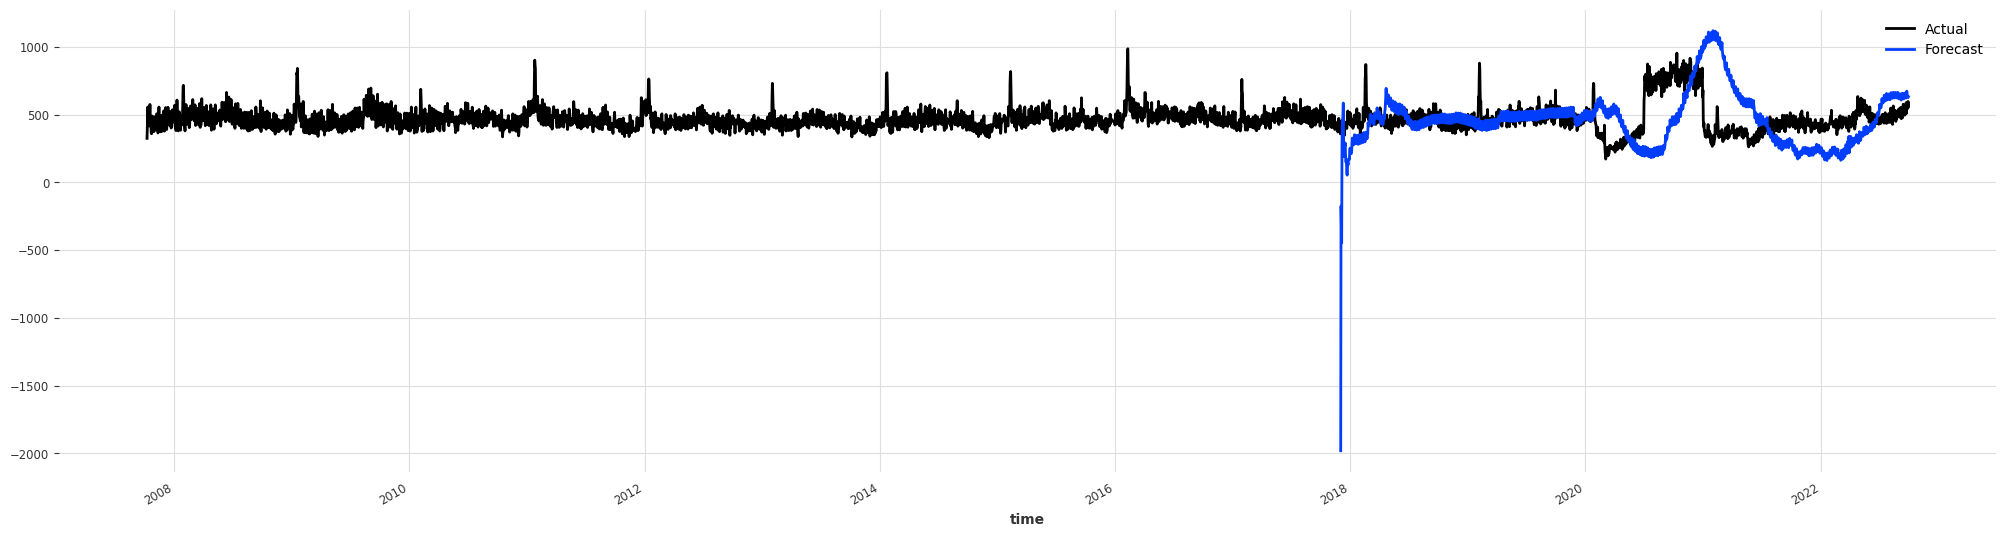

In [66]:
df_combined = pd.concat([train_df, test_df])
all_series = TimeSeries.from_dataframe(df_combined, value_cols='No' )
#No_array = all_series['No'].values
# Compute MAPE error using the original 'test_series' and the inverse-transformed predictions
MAPE = mape(all_series, Model_prediction_ts_inverse)
MAE = mae(all_series, Model_prediction_ts_inverse)

print(f"MAPE: {MAPE}%")
print(f"MAE: {MAE}")

# Plotting
plt.figure(figsize=(25, 6))
all_series.plot(label="Actual")
Model_prediction_ts_inverse.plot(label="Forecast")
plt.legend()
plt.show()

In [67]:
yearly_dataarrays = {}

for year in range(2017, 2023):  # 从2017到2022
    # 使用TimeSeries的slice方法按年份切片
    # 注意：这里假设时间索引类型是pd.DatetimeIndex
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    
    # 将每年的TimeSeries转换为DataArray并存储在字典中
    yearly_dataarrays[year] = yearly_series.data_array()

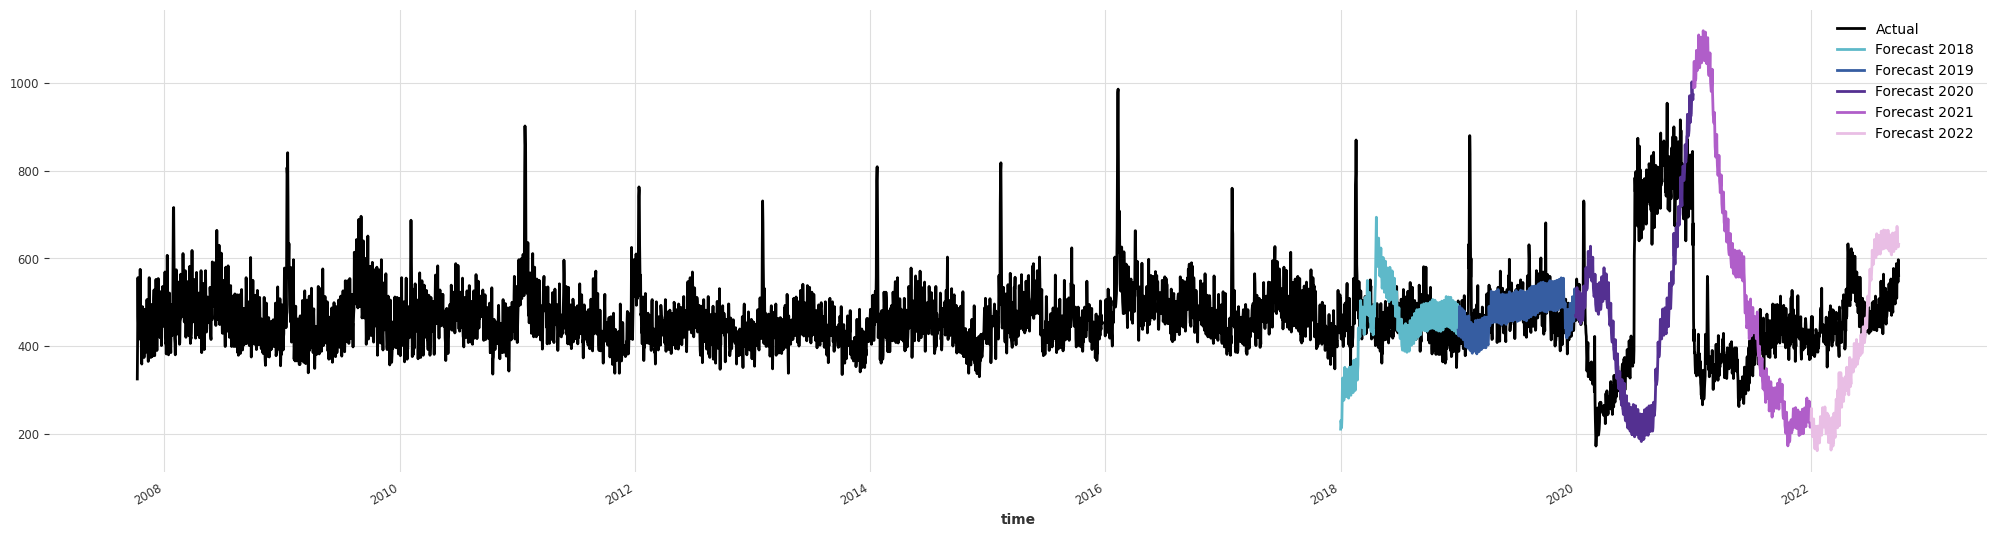

In [68]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
all_series.plot(label="Actual")

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [69]:
metrics = {}

for year in range(2018, 2023):
    # 从all_series中提取相应年份的实际数据
    actual = all_series.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))

    # 从yearly_dataarrays中获取预测数据并将其转换为TimeSeries
    forecast = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 确保预测数据的时间范围至少与实际数据相交
    # 这里不需要手动对齐，因为mae和mape函数会自动处理
    # 直接计算MAE和MAPE
    metrics[year] = {
        "MAE": mae(actual, forecast),
        "MAPE": mape(actual, forecast)
    }

# 打印结果
for year, m in metrics.items():
    print(f"Year {year}: MAE = {m['MAE']}, MAPE = {m['MAPE']}%")


Year 2018: MAE = 71.76774287880832, MAPE = 15.445078392746439%
Year 2019: MAE = 35.615953222750825, MAPE = 7.11046724469054%
Year 2020: MAE = 242.65607744353093, MAPE = 47.467611274804725%
Year 2021: MAE = 286.46712165594465, MAPE = 77.9773856836854%
Year 2022: MAE = 158.92222167427894, MAPE = 33.95954569806205%


In [70]:
Model_prediction_df_inverse.to_csv(path_or_buf='timeseries/TrainingResult/prophet30/Chayi/forecast2018.csv')